Copyright 2021 Vector Informatik GmbH
SPDX-License-Identifier: MIT 
Contact: khanlian.chung@vector.com

# Notebook for exploring and playing with saliency maps and backprop with Torch

In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## A few helper functions to load an arbitrary image and generate a simple grey-value heatmap
Some helper function to pre and post processing the inputs.

In [2]:
def prep_input(path):
    image =Image.open(path)

    preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

    image = preprocess(image)
    image.unsqueeze_(0)

    return image

def decode_output(output):
    # taken and modified from https://pytorch.org/hub/pytorch_vision_alexnet/
    import urllib.request
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    urllib.request.urlretrieve(url, "imagenet_classes.txt")
    # Read the categories
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    return top5_catid[0]

def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)


    return out

def get_lion():
    # Wikipedia lion image https://en.wikipedia.org/wiki/Lion#/media/File:Lion_waiting_in_Namibia.jpg
    # License: CC BY 2.0 https://creativecommons.org/licenses/by/2.0/deed.en
    import urllib.request
    filename = 'lion.jpg'
    img_url = r"https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg"
    urllib.request.urlretrieve(img_url, filename)

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")

def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm


This example is built upon a DenseNet201. But you can interchange it any other network. Simpliest way would be: change torchvision.models.densenet201(True) to another network such as torchvision.models.resnet18(True). Have a look at https://pytorch.org/vision/stable/models.html
If you are interested in the imagenet data, have a look here: https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=imagenet2012

In [3]:
test_model = torchvision.models.densenet201(True)
test_model.eval()
get_lion()
input_img = prep_input("lion.jpg")

## Vanilla backprop for saliency map:
After setting everything up, we have to explicitly instruct PyTorch to calculate and keep the gradients for the input image input_img. This is managed by the .requires_grad flag. 

In [4]:
input_img.requires_grad = True
# forward/inference
out = test_model(input_img)
best_id = decode_output(out)
# backprop
out[0, best_id].backward()
grads = input_img.grad


lion 0.9958244562149048
collie 0.0027406620793044567
Shetland sheepdog 0.0003924183256458491
cheetah 0.0002545712050050497
chow 8.904379501473159e-05


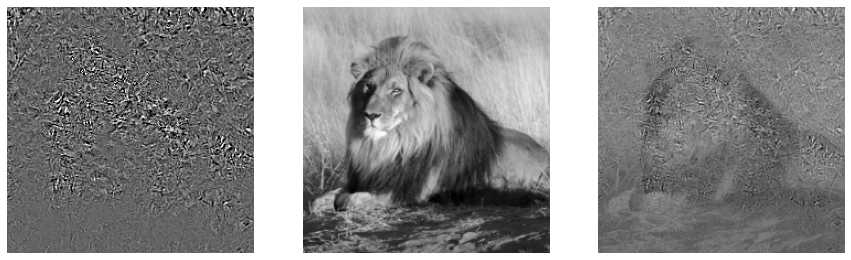

In [5]:
plot_maps(norm_flat_image(grads),norm_flat_image(input_img) )


In [6]:
import napari
viewer = napari.view_image(norm_flat_image(grads))
viewer.add_image(norm_flat_image(input_img))

<Image layer 'Image [1]' at 0x2032eb69100>